<h3> DATA COLUMNS: </h3>

marketplace       - 2 letter country code of the marketplace where the review was written.<br>
customer_id       - Random identifier that can be used to aggregate reviews written by a single author.<br>
review_id         - The unique ID of the review.<br>
product_id        - The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.<br>
product_parent    - Random identifier that can be used to aggregate reviews for the same product.<br>
product_title     - Title of the product.<br>
product_category  - Broad product category that can be used to group reviews (also used to group the dataset into coherent parts).<br>
star_rating       - The 1-5 star rating of the review.<br>
helpful_votes     - Number of helpful votes.<br>
total_votes       - Number of total votes the review received.<br>
vine              - Review was written as part of the Vine program.<br>
verified_purchase - The review is on a verified purchase.<br>
review_headline   - The title of the review.<br>
review_body       - The review text.<br>
review_date       - The date the review was written.<br>


In [4]:
# LOADING REQUIRED LIBRARIES & making connection to local spark instance
library(ggplot2)
library(sparklyr)
library(data.table)
library(dplyr)
library(tidyr)
sc <- spark_connect(master = "local")

Re-using existing Spark connection to local



In [5]:
path = 'amazon_data.csv'

In [6]:
# reading the 'csv' file in sparklyr

df_new <- spark_read_csv(sc, path, delimeter=',', header=TRUE)

In [7]:
df_new

# Source: spark<amazon_data_f3085944_8142_4818_aa40_c42409faef2e> [?? x 15]
   marketplace customer_id review_id  product_id product_parent product_title   
   <chr>             <int> <chr>      <chr>               <int> <chr>           
 1 US               650634 R3EQSTM9P~ B0091LBZSU      578484426 Demograss Capsu~
 2 US             19827510 RBWPRK17X~ B00PWW3LQ6      456433146 Viva Labs #1 Pr~
 3 US              1520474 RRSLOAF27~ B00DKEWA92      460764511 Whip-it Cleaner 
 4 US             23905905 R3S8W9Q6S~ B0015R3A7M      135102038 Optimum Nutriti~
 5 US             28215779 R3QQ6NSLR~ B006B8U8BG      200666829 Wet-Stop3 Bedwe~
 6 US             23260912 R2XYDBMHU~ B00PFZFD8Y      344168617 NatraCure Plant~
 7 US              7965616 R1L94ESVC~ B0034792JG      291831570 Glade Sense & S~
 8 US              3443178 R3DI4B8LD~ B000052XIA      493678550 Vagisil Anti-It~
 9 US             20838781 R1G7VV4HC~ B004GCUK8A        3902598 Glade Automatic~
10 US             15267517 R3TTNY

In [8]:
# Collecting the spark data in R dataframe
df <- collect(df_new)

In [9]:
summary(df)

 marketplace         customer_id        review_id          product_id       
 Length:10298       Min.   :   12598   Length:10298       Length:10298      
 Class :character   1st Qu.:12723480   Class :character   Class :character  
 Mode  :character   Median :23585790   Mode  :character   Mode  :character  
                    Mean   :25557656                                        
                    3rd Qu.:40547380                                        
                    Max.   :53090974                                        
 product_parent      product_title      product_category   star_rating       
 Min.   :   315981   Length:10298       Length:10298       Length:10298      
 1st Qu.:267880176   Class :character   Class :character   Class :character  
 Median :503485595   Mode  :character   Mode  :character   Mode  :character  
 Mean   :505436641                                                           
 3rd Qu.:754596439                                                     

# 1. Top Products sold

In [11]:
df_top <- head(sort(table(df$product_title), decreasing = TRUE))
data.frame(df_top)

Var1,Freq
<fct>,<int>
Fitbit Charge HR Wireless Activity Wristband,62
Fitbit Charge Wireless Activity Wristband,34
Doctor Danielle Turmeric Curcumin with Bioperine (120 Capsules),33
"Omega 3 Fish Oil Pills - Triple Strength Fish Oil Supplement (1,400mg Omega 3 Fatty Acids: 600mg DHA + 800 mg EPA per Serving) - Burpless Capsules with Enteric Coating And Pharmaceutical Grade Essential Fatty Acids - Molecularly Distilled Fish Oil Supplements Including Best Health Bonus (Online Videos With Health-Supporting Exercises)",28
"Fitbit Flex Wireless Wristband with Sleep Function, Black",24
Amazon Elements Wipes,23


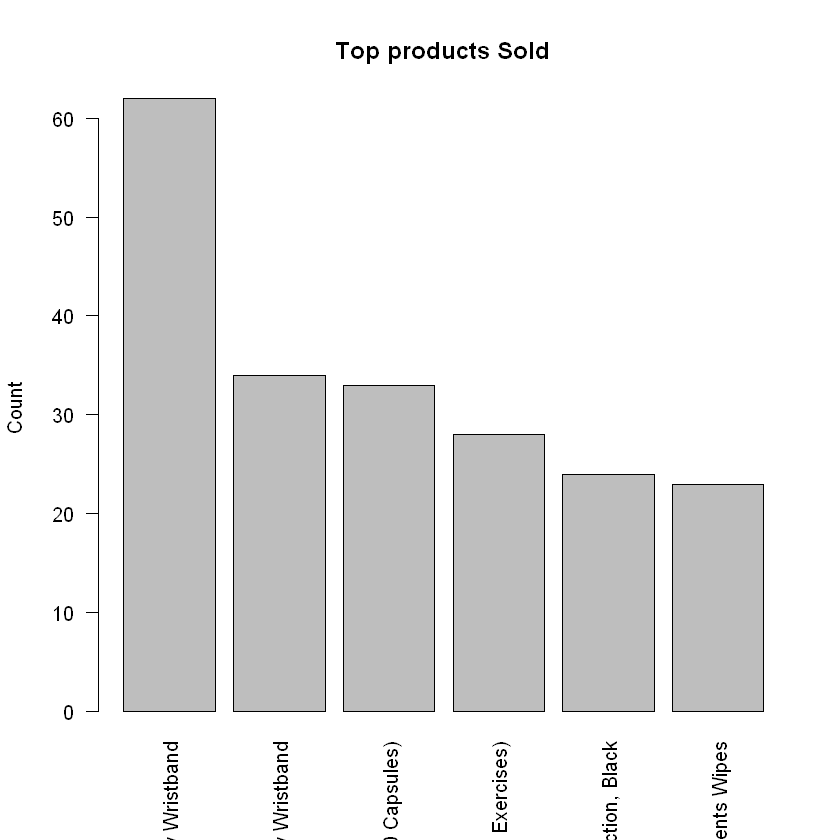

In [9]:
barplot(df_top,
main="Top products Sold",
ylab="Count",
las=2,
)

### Data preprocessing

In [10]:
df_temp <- data.frame(df_top)
df_temp <- subset (df_temp, select = -Freq)

In [11]:
df_temp <- df_temp %>% 
  rename(
    product_title = Var1
    )

# 2. Minimum and Maximum Rating for top products

In [12]:
temp <- data.frame(df[,c(6,8)])

In [13]:
max_rat <- function(name){
    a<-data.frame(table(subset(temp, product_title == name)))
    a$star_rating <- as.numeric(as.character(a$star_rating))
    return (max(a$star_rating))
}

In [14]:
max_rat_count <- function(name) {
    max_count <- max(table(subset(temp, product_title == name)))
    return (max_count)
}

In [15]:
min_rat <- function(name){
    a<-data.frame(table(subset(temp, product_title == name)))
    a$star_rating <- as.numeric(as.character(a$star_rating))
    return (min(a$star_rating))
}

In [16]:
min_rat_count <- function(name) {
    max_count <- min(table(subset(temp, product_title == name)))
    return (max_count)
}

In [17]:
df_temp$max_rating <- lapply(df_temp$product_title, max_rat)
df_temp$min_rating <- lapply(df_temp$product_title, min_rat)
df_temp$max_rating_count <- lapply(df_temp$product_title, max_rat_count)
df_temp$min_rating_count <- lapply(df_temp$product_title, min_rat_count)

In [19]:
df_temp

,product_title,max_rating,min_rating,max_rating_count,min_rating_count
,<fct>,<list>,<list>,<list>,<list>
1,Fitbit Charge HR Wireless Activity Wristband,5,1,34,4
2,Fitbit Charge Wireless Activity Wristband,5,1,18,3
3,Doctor Danielle Turmeric Curcumin with Bioperine (120 Capsules),5,1,23,1
4,"Omega 3 Fish Oil Pills - Triple Strength Fish Oil Supplement (1,400mg Omega 3 Fatty Acids: 600mg DHA + 800 mg EPA per Serving) - Burpless Capsules with Enteric Coating And Pharmaceutical Grade Essential Fatty Acids - Molecularly Distilled Fish Oil Supplements Including Best Health Bonus (Online Videos With Health-Supporting Exercises)",5,1,20,1
5,"Fitbit Flex Wireless Wristband with Sleep Function, Black",5,1,14,1
6,Amazon Elements Wipes,5,1,14,1


In [37]:
# formattedData <- df_temp %>% select(product_title, max_rating, min_rating) %>% pivot_longer(cols = all_of(c("max_rating", "min_rating"))) 

In [38]:
# ggplot(formattedData, aes(x = product_title, y = value, fill = name)) + geom_bar(stat = "identity", position = "dodge") + scale_fill_manual(values=c("max_rating" = "orange", "min_rating" = "blue")) + ggtitle("Top products ratings") + ylab("Ratings")

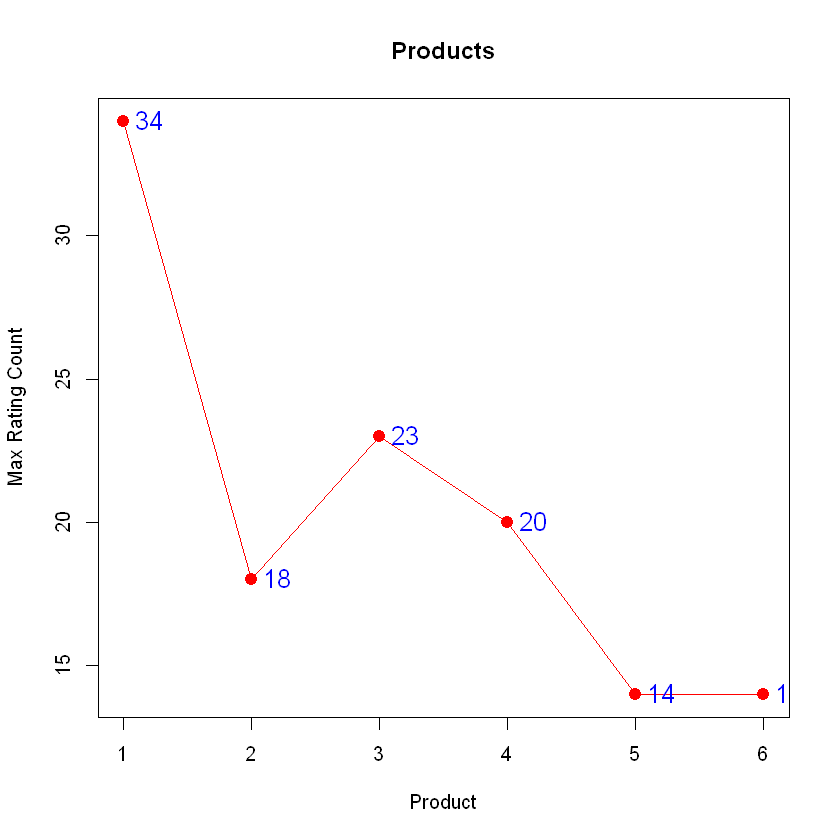

In [22]:
plot(x = df_temp$product_title, y = df_temp$max_rating_count, type='o', xlab = "Product", ylab = "Max Rating Count", main = "Products", col="red",pch = 19,cex = 1.3)

text(x = df_temp$product_title,
     y = df_temp$max_rating_count,
     labels = df_temp$max_rating_count,cex=1.3, pos=4,col="blue")

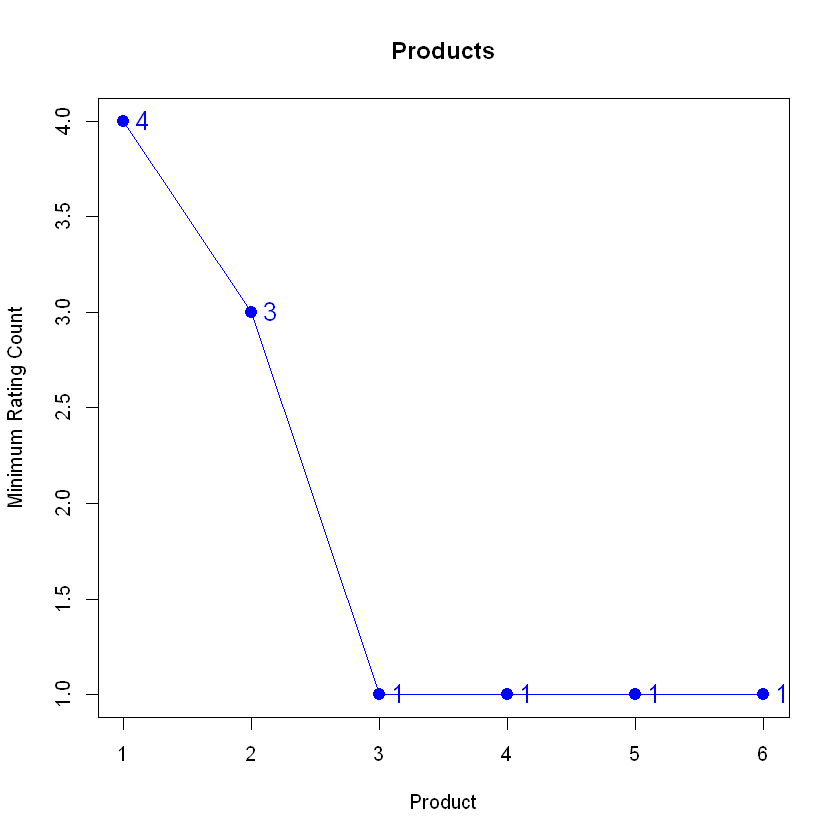

In [23]:
plot(x=df_temp$product_title, y=df_temp$min_rating_count, type = "o", col = "blue", xlab = "Product",ylab = "Minimum Rating Count", main = "Products", pch = 19,cex = 1.3)
text(x = df_temp$product_title,
     y = df_temp$min_rating_count,
     labels = df_temp$min_rating_count,cex=1.3, pos=4,col="blue")

# 3. Sentiment Analysis of Review Headlines

In [24]:
library(sentimentr)

In [25]:
df$sentiment <- sentiment_by(df$review_headline)$ave_sentiment

Warning message:
"Each time `sentiment_by` is run it has to do sentence boundary disambiguation when a
raw `character` vector is passed to `text.var`. This may be costly of time and
memory.  It is highly recommended that the user first runs the raw `character`
vector through the `get_sentences` function."


In [26]:
head(df)

marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
US,650634,R3EQSTM9PWRAL,B0091LBZSU,578484426,Demograss Capsules Diet Pills Lose Weight,Health & Personal Care,3,0,0,N,Y,Three Stars,Only came with 30 pills I wish it would've came with at least 50,2015-08-31,0.0000000
US,19827510,RBWPRK17XKIXD,B00PWW3LQ6,456433146,"Viva Labs #1 Premium Himalayan Organic Goji Berries, Noticeably Larger and Juicier",Health & Personal Care,5,0,0,N,Y,A good portable snack,Really yummy and healthy. A good portable snack.,2015-08-31,0.7000000
US,1520474,RRSLOAF273XFC,B00DKEWA92,460764511,Whip-it Cleaner,Health & Personal Care,5,1,2,N,Y,You need this,You cannot go wrong with this stuff. I use it in my laundry & my carpet steamer and also just for general cleaning in my kitchen and bathroom. I have 3 dogs and this keeps my creme colored carpets looking new. Also works great as a deodorizer in my air washer. Buy it!,2015-08-31,0.0000000
US,23905905,R3S8W9Q6SWIT8O,B0015R3A7M,135102038,"Optimum Nutrition Opti-Men Daily Multivitamin Supplement, 90 Count",Health & Personal Care,4,0,0,N,Y,this is a good vitamin for men,This is a good daily vitamin for men.,2015-08-31,0.2834734
US,28215779,R3QQ6NSLRVBFJC,B006B8U8BG,200666829,"Wet-Stop3 Bedwetting Enuresis Alarm with Loud Sound and Strong Vibration for Boys or Girls, Proven Solutions for Bedwetters",Health & Personal Care,4,0,0,N,Y,progress is definitely happening!!!!,We have been using this for almost a month and so far it's worked out really well! My son is actually waking up when the alarm sounds and changes his bottoms if he needs to or finishes in the bathroom! Before the alarm he wouldn't wake up for any type of noise!!! He has more gold stars on his board than silver and it has boosted his confidence! We are happy!<br />The only thing it does and we don't know why is that it will randomly sound even if he's dry.. Not sure if that's supposed to happen or not but its not too often so we just ignore it and shut it off!,2015-08-31,0.6750000
US,23260912,R2XYDBMHUVJCSX,B00PFZFD8Y,344168617,NatraCure Plantar Fasciitis Wrap (One Wrap) - 1291-S CAT Arch Support (Small/Medium),Health & Personal Care,2,0,1,N,Y,Two Stars,I wear it a few times only but the fabric cover the jelly pad already broken.,2015-08-31,0.0000000


In [27]:
df$sentimentanalysis <- ifelse(df$star_rating > 3,'positive', 'negative')

In [28]:
head(df)

marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment,sentimentanalysis
<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
US,650634,R3EQSTM9PWRAL,B0091LBZSU,578484426,Demograss Capsules Diet Pills Lose Weight,Health & Personal Care,3,0,0,N,Y,Three Stars,Only came with 30 pills I wish it would've came with at least 50,2015-08-31,0.0000000,negative
US,19827510,RBWPRK17XKIXD,B00PWW3LQ6,456433146,"Viva Labs #1 Premium Himalayan Organic Goji Berries, Noticeably Larger and Juicier",Health & Personal Care,5,0,0,N,Y,A good portable snack,Really yummy and healthy. A good portable snack.,2015-08-31,0.7000000,positive
US,1520474,RRSLOAF273XFC,B00DKEWA92,460764511,Whip-it Cleaner,Health & Personal Care,5,1,2,N,Y,You need this,You cannot go wrong with this stuff. I use it in my laundry & my carpet steamer and also just for general cleaning in my kitchen and bathroom. I have 3 dogs and this keeps my creme colored carpets looking new. Also works great as a deodorizer in my air washer. Buy it!,2015-08-31,0.0000000,positive
US,23905905,R3S8W9Q6SWIT8O,B0015R3A7M,135102038,"Optimum Nutrition Opti-Men Daily Multivitamin Supplement, 90 Count",Health & Personal Care,4,0,0,N,Y,this is a good vitamin for men,This is a good daily vitamin for men.,2015-08-31,0.2834734,positive
US,28215779,R3QQ6NSLRVBFJC,B006B8U8BG,200666829,"Wet-Stop3 Bedwetting Enuresis Alarm with Loud Sound and Strong Vibration for Boys or Girls, Proven Solutions for Bedwetters",Health & Personal Care,4,0,0,N,Y,progress is definitely happening!!!!,We have been using this for almost a month and so far it's worked out really well! My son is actually waking up when the alarm sounds and changes his bottoms if he needs to or finishes in the bathroom! Before the alarm he wouldn't wake up for any type of noise!!! He has more gold stars on his board than silver and it has boosted his confidence! We are happy!<br />The only thing it does and we don't know why is that it will randomly sound even if he's dry.. Not sure if that's supposed to happen or not but its not too often so we just ignore it and shut it off!,2015-08-31,0.6750000,positive
US,23260912,R2XYDBMHUVJCSX,B00PFZFD8Y,344168617,NatraCure Plantar Fasciitis Wrap (One Wrap) - 1291-S CAT Arch Support (Small/Medium),Health & Personal Care,2,0,1,N,Y,Two Stars,I wear it a few times only but the fabric cover the jelly pad already broken.,2015-08-31,0.0000000,negative


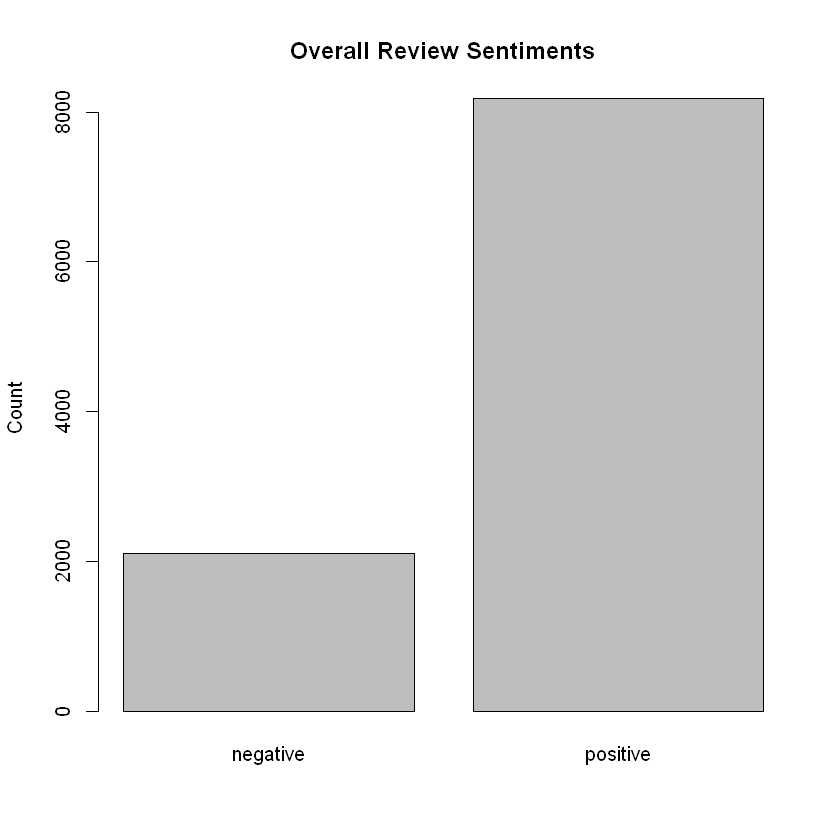

In [29]:
barplot(table(df$sentimentanalysis), ylab = 'Count', main = 'Overall Review Sentiments')